In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time
import plotly
import plotly.graph_objs as go
from sklearn.metrics import accuracy_score, classification_report


This notebook compares  four different models to predict the outcome of individual pitches in the 2024 Major League Baseball season. The models that are compared are:
1. Decision trees
2. Random forest
3. Neural network
4. XGBoost

Models are evaluation using the following metrics: 

1. Accuracy - overall, how many predictions were correctly classified?
2. Sensitivity - for each class, how many were correct classified?

Before training the models the data will be split into training (60%), validation (20%) and test (20%) sets. Models are trained on the training data and performance is tested on the validation set. Only the final model is tested on the test set to obtain a true estimate of model performance.


### reading in data  

The data set has already been cleaned (please see importing and cleaning notebook). It includes Principal component analysis for batters and pitchers seasonal average. These are detailed in a separate notebook. 

In [2]:

df = pd.read_csv("Data/pitchbypitch24_cleaned.csv") #this data set is included in the github repo

In [55]:
#for reproducibility of sampling and data splits below
import random
random.seed(10)

### Balancing outcome groups

The outcomes in the dataset are unbalanced. 'Balls' make up 44% of the data whereas solid contact only makes up 8%. Some models struggle with unbalanced classes as the model is less likely to predict the less frequent classes. Since the sample size is quite large, we can undersample the necessary categories to match the smallest category.

**Note:** this approach could potentially introduce bias into the data as we are discarding a large proportion of the sample and potentially losing valuable information. 


In [56]:
df.outcome.value_counts()

outcome
Ball               245611
Called strike      112993
Swinging strike     76587
Weak contact        74059
Solid contact       46344
Name: count, dtype: int64

In [57]:
# balancing outcome groups
strikes = df[df["outcome"]== "Called strike"]
sw_strikes = df[df["outcome"]== "Swinging strike"]
balls = df[df["outcome"]== "Ball"]
weak = df[df["outcome"]== "Weak contact"]
solid = df[df["outcome"]== "Solid contact"]

strikes_samp = strikes.sample(len(solid), random_state=1)
sw_strikes_samp = sw_strikes.sample(len(solid), random_state=1)
balls_samp = balls.sample(len(solid), random_state=1)
weak_samp = weak.sample(len(solid), random_state=1)
#solid_samp = solid.sample(50000, random_state=1)

df_samp = pd.concat([strikes_samp, sw_strikes_samp, balls_samp,weak_samp, solid])



The outcome groups are now balanced with the same proportion of data in each class

In [58]:
df_samp.outcome.value_counts()

outcome
Called strike      46344
Swinging strike    46344
Ball               46344
Weak contact       46344
Solid contact      46344
Name: count, dtype: int64

### Descriptive analysis of pitch by pitch data

Before training the models, it is useful to understand a bit more about the data and how different variables relate to one another. We will plot the strike zone using the plate_x and plate_z variables, representing the horizontal and vertical position of the ball when it crosses home plate.  

A subsample of the data is used to make the plots easier to read.

(descriptive statistics for the seasonal averages are included in the "principal component analysis" jupyter notebook.)

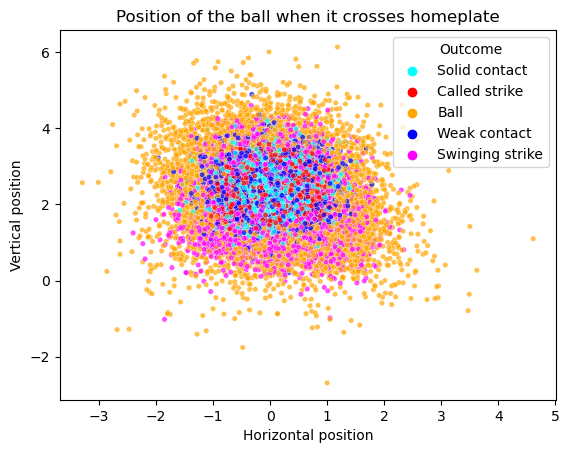

In [71]:
data = df_samp.sample(frac=0.1, random_state=1)

#define a custom palette

# Define custom colors for each outcome
custom_palette = {
    'Called strike': 'red',
    'Swinging strike': 'magenta',
    'Ball': 'orange',
    'Weak contact': 'blue',
    'Solid contact': 'cyan'
}
# plotting outcome against strike zone (plate x and plate z)
sns.scatterplot(data=data, x='plate_x', y='plate_z', hue='outcome', palette=custom_palette, s=15, alpha =0.7)

plt.title("Position of the ball when it crosses homeplate")
plt.xlabel("Horizontal position")
plt.ylabel("Vertical position")
plt.legend(title="Outcome")
plt.show()

As expected, balls are occuring outside the strike zone. Similarly called strikes are in the center as these would always be in the strike zone. Many swinging strikes occur at the bottom of the strike zone. Solid contact tends to cluster in the center of the strike zone as the 'optimal' spot 

We can also plot this looking at left handed and right handed pitchers to see how this differs

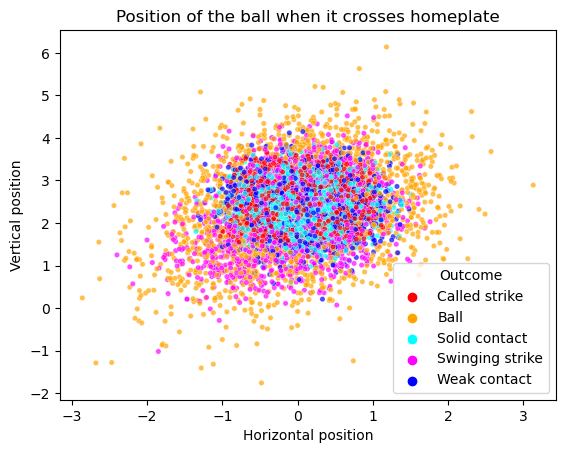

In [72]:

X = data[data["p_throws"] =="L"]
# Seaborn Scatterplot (automatically assigns colors to categories)
sns.scatterplot(data=X, x='plate_x', y='plate_z', hue='outcome', palette=custom_palette, s=15, alpha =0.7)

plt.title("Position of the ball when it crosses homeplate")
plt.xlabel("Horizontal position")
plt.ylabel("Vertical position")
plt.legend(title="Outcome")
plt.show()

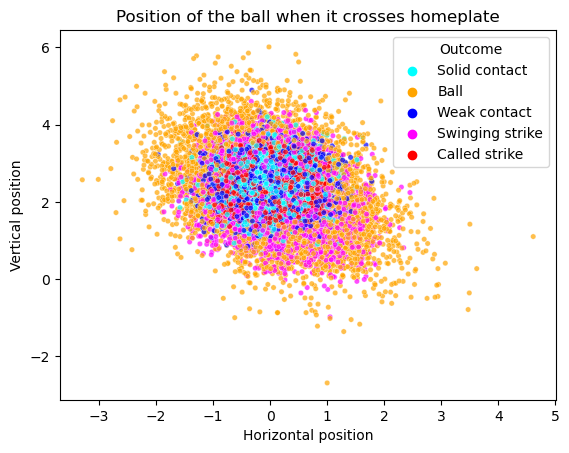

In [73]:

X = data[data["p_throws"] =="R"]
# Seaborn Scatterplot (automatically assigns colors to categories)
sns.scatterplot(data=X, x='plate_x', y='plate_z', hue='outcome', palette=custom_palette, s=15, alpha =0.7)

plt.title("Position of the ball when it crosses homeplate")
plt.xlabel("Horizontal position")
plt.ylabel("Vertical position")
plt.legend(title="Outcome")
plt.show()

We can also look at how the pitch statistics are related to one another using pairwise plots.  These plots show the relationship of velocity and acceleration of the pitch

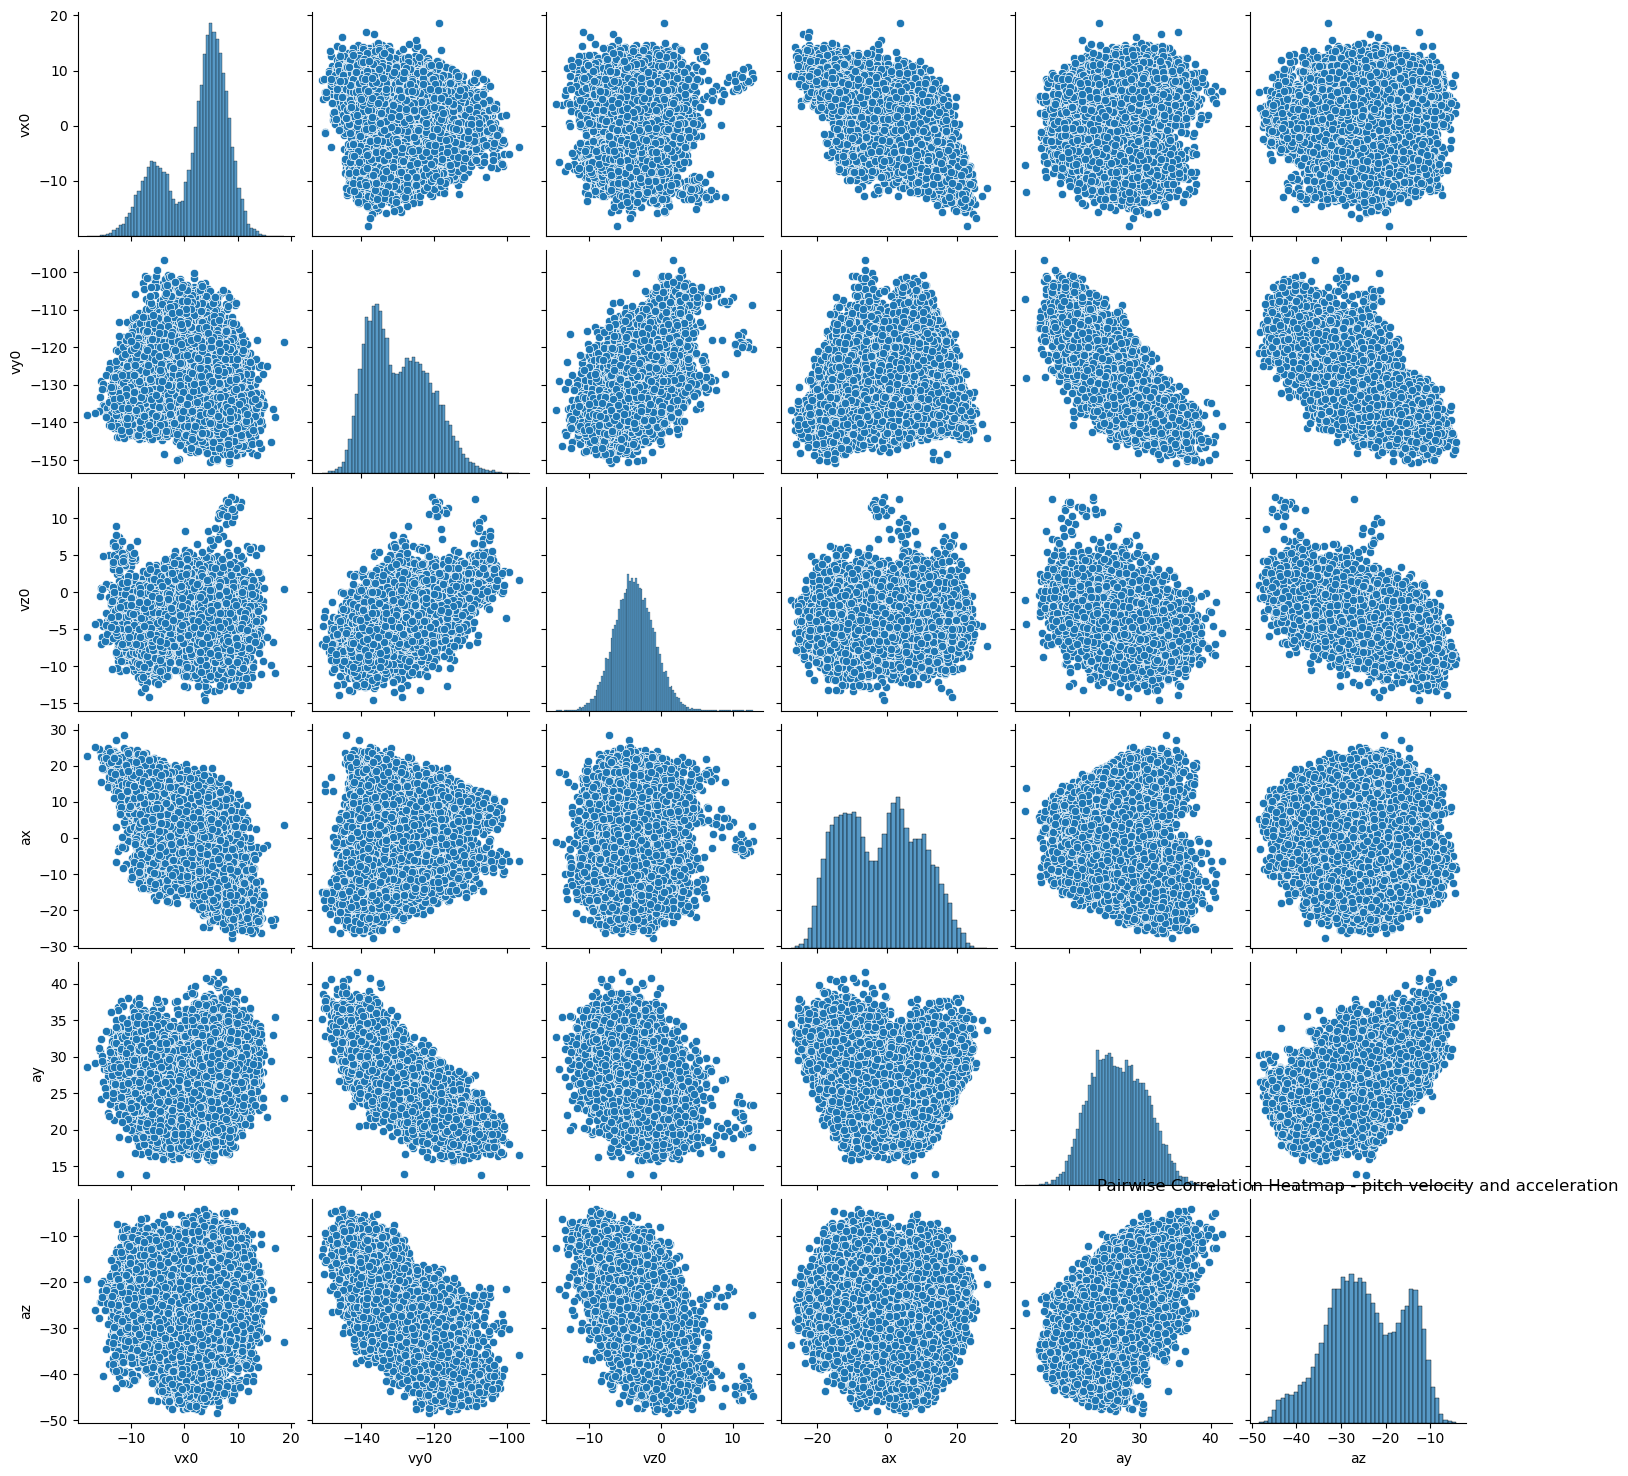

In [22]:
import warnings

# Suppress warnings only for this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.pairplot(data[[ 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',]])
    plt.title("Pairwise Correlation Heatmap - pitch velocity and acceleration")
    plt.show()

The plots show that there is some correlation between pitch velocity and acceleration across the same dimensions but shows considerable variability in the data. 

### set up data sets

To set up the datasets for modelling, firstly, the outcome variable needs to be separated from the data set - this is labelled y. The remaining data is labelled X. 

The variable 'zone' is recoded to be a categorical variable. Although these are integers from 1-14 and may seem like a continuous variable, it represents sections of the strike zone therefore it is a categorical variable. 

Columns that are not used in the analysis (only used to identify records) are removed at this stage. 

All categorical variables are also recoded to dummy variables. 

Finally outcome is remapped to integers 

In [24]:
#Create a mapping of categories to numbers
outcome_map = {'Ball': 0, 'Called strike': 1, "Swinging strike" : 2,'Weak contact': 3, 'Solid contact': 4}

#Apply the mapping to the column
df_samp['outcome'] = df_samp['outcome'].map(outcome_map)

In [25]:
df_samp.outcome.value_counts()

outcome
1    46344
2    46344
0    46344
3    46344
4    46344
Name: count, dtype: int64

In [26]:
y = pd.Series(df_samp.outcome, name="outcome")
X = df_samp.drop(labels="outcome",axis=1)
X['zone'] = X['zone'].astype('category')

cols_drop = ["player_name","batter_id","pitcher_id","pitch_name", "pitcher.1", "Name", "team_abbrev","type",
             "pitch_type","balls", "strikes", "outcome2", "pa", "team_abbrev_pitch", "xhr", "xhr_pitch"] #dropping vars not used in analysis

X = X.drop(labels=cols_drop,axis=1)
X = pd.get_dummies(X)


Finally data is split into training (60%), validation (20%) and test data (20%). Models are trained on the training data and performance is tested on the validation set. Only the final model is tested on the test set to obtain a true estimate of model performance. 


In [27]:
# Step 1: Split data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# (test_size=0.25 here will split the remaining 80% data, so 0.25 * 0.8 = 0.2 of the original data)


In [28]:
len(X_train), len(X_val), len(X_test)

(139032, 46344, 46344)

In [29]:
#confirm that proportion of outcomes are balanced in the training set.
y_train.value_counts(normalize = True, dropna = False)

outcome
1    0.200745
2    0.200414
0    0.199731
4    0.199681
3    0.199429
Name: proportion, dtype: float64

## Modelling

#### Decision Tree

A decision tree is a fairly simple machine learning approach, and unlikely to yield very good results, however the benefit of decision trees are in their interpretability and it is useful to see which variables are the most important. 

Before running decision trees, all columns that are used in the principal component analysis are removed from the train and validation set. The original data set is preserved as it is used in other models. 

In [104]:
#dropping columns that are in PCA 

cols_drop = ['k_percent','bb_percent', 'xba', 'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent',
       'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent',
       'hard_hit_percent', 'avg_hyper_speed', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'iz_contact_percent', 'xhr_rate', 'k_percent_pitch',
       'bb_percent_pitch', 'xba_pitch', 'xslg_pitch', 'xwoba_pitch',
       'xwobacon_pitch', 'sweet_spot_percent_pitch',
       'barrel_batted_rate_pitch', 'solidcontact_percent_pitch',
       'flareburner_percent_pitch', 'poorlyunder_percent_pitch',
       'poorlytopped_percent_pitch', 'poorlyweak_percent_pitch',
       'hard_hit_percent_pitch', 'avg_hyper_speed_pitch',
       'z_swing_percent_pitch', 'z_swing_miss_percent_pitch',
       'oz_swing_percent_pitch', 'oz_swing_miss_percent_pitch', 'xhr_rate_pitch'] #these variables are the seasonal average stats for pitchers and batter which are included in the PCA 


X_train_dt = X_train.drop(labels=cols_drop,axis=1)
X_val_dt = X_val.drop(labels=cols_drop,axis=1)


In [106]:
X_train_dt.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'inning', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'release_pos_y',
       'at_bat_number', 'pitch_number', 'spin_axis', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC1_pitch', 'PC2_pitch', 'PC3_pitch', 'PC4_pitch',
       'on_base', 'run_diff', 'zone_1.0', 'zone_2.0', 'zone_3.0', 'zone_4.0',
       'zone_5.0', 'zone_6.0', 'zone_7.0', 'zone_8.0', 'zone_9.0', 'zone_11.0',
       'zone_12.0', 'zone_13.0', 'zone_14.0', 'stand_L', 'stand_R',
       'p_throws_L', 'p_throws_R'],
      dtype='object')

In [107]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

To train the max_depth of the decision tree the model is trained iteratively setting max depth from 1 to 20. The highest validation score is the best depth. 

In [108]:
bestdepth=-1
bestscore=0
max_depth = 20


for i in range(max_depth):
    clf = DecisionTreeClassifier(max_depth=i+1)
    clf.fit(X_train_dt,y_train)
    trainscore=clf.score(X_train_dt,y_train)
    valscore=clf.score(X_val_dt,y_val)
    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Valid Score:', valscore)

    if valscore>bestscore:
        bestscore=valscore
        bestdepth=i+1

Depth: 1 Train Score: 0.26929771563381094 Valid Score: 0.27084412221646814
Depth: 2 Train Score: 0.30864836872087004 Valid Score: 0.3103314344899016
Depth: 3 Train Score: 0.34616491167501007 Valid Score: 0.3458484377697221
Depth: 4 Train Score: 0.3794018643190057 Valid Score: 0.37914293112377007
Depth: 5 Train Score: 0.4318214511767075 Valid Score: 0.42749870533402384
Depth: 6 Train Score: 0.436985729903907 Valid Score: 0.4299801484550319
Depth: 7 Train Score: 0.4391435065308706 Valid Score: 0.43136112549628863
Depth: 8 Train Score: 0.4483787904942747 Valid Score: 0.4381581218712239
Depth: 9 Train Score: 0.46050549513781003 Valid Score: 0.44318574141204903
Depth: 10 Train Score: 0.47560993152655506 Valid Score: 0.4519894700500604
Depth: 11 Train Score: 0.49126819724955406 Valid Score: 0.4554850681857414
Depth: 12 Train Score: 0.5088612693480637 Valid Score: 0.456930778525807
Depth: 13 Train Score: 0.5296838137982622 Valid Score: 0.46034006559640944
Depth: 14 Train Score: 0.548600322227

In [111]:
#fitting decision tree with the best depth 

clf = DecisionTreeClassifier(max_depth=bestdepth, random_state=10)
clf.fit(X_train_dt, y_train)

print ( 'training accuracy ',clf.score(X_train_dt, y_train), 'validation accuracy', clf.score(X_val_dt, y_val))

y_pred = clf.predict(X_val_dt)

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)



training accuracy  0.529640658265723 validation accuracy 0.46025375453133094


As expected the accuracy is fairly low with 46% accuracy. However it still performs better than chance which would be 20%. We can also output the results as a confusion matrix (these have been converted to percentages representing the proportion of successful predictions for each given class (sensitivity))

accuracy of specific classes (sensitivity): balls: 0.651 strikes: 0.598 swinging strikes: 0.363 Weak contact: 0.219 Solid contact: 0.469


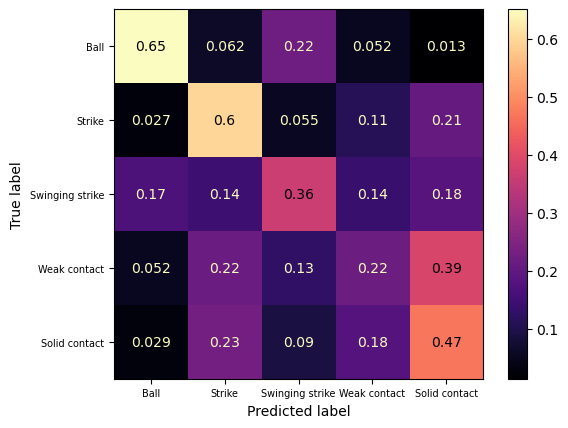

In [117]:
cm = confusion_matrix(y_val, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmd = ConfusionMatrixDisplay(cmn, display_labels=["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"])
cmd.plot(cmap="magma")
plt.xticks(fontsize=7)  # Reduce font size for x-axis labels
plt.yticks(fontsize=7)

acc_ball =cm[0,0] / sum(cm[0,:]) 
acc_strike = cm[1,1] / sum(cm[1,:]) 
acc_sw_strike = cm[2,2] / sum(cm[2,:]) 
acc_weak =cm[3,3] / sum(cm[3,:]) 
acc_solid =cm[4,4] / sum(cm[4,:]) 

print("accuracy of specific classes (sensitivity):","balls:",round(acc_ball,3), "strikes:", round(acc_strike,3), "swinging strikes:", 
      round(acc_sw_strike,3), "Weak contact:",round(acc_weak,3), "Solid contact:", round(acc_solid,3))



we will output the results into a classification report which will be used for comparison later on

In [132]:
report_dt = classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"],
                           output_dict = True)
print(classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"]))

                 precision    recall  f1-score   support

           Ball       0.70      0.65      0.68      9356
         Strike       0.48      0.60      0.53      9255
Swinging strike       0.42      0.36      0.39      9307
   Weak contact       0.31      0.22      0.26      9253
  Solid contact       0.37      0.47      0.41      9173

       accuracy                           0.46     46344
      macro avg       0.46      0.46      0.45     46344
   weighted avg       0.46      0.46      0.45     46344



We can also plot the list of features importances. From the plot we can see that 'plate_z' and 'plate_x' are the most important. This is unsurprising as it effectively represents the strike zone and how most balls are likely to be categorised. The principal compontents of the batter are also high up, which would be expected as the batters skill should be predictive of outcome.

In [133]:

def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Feature Importances")
    fig.tight_layout()
    plt.show()

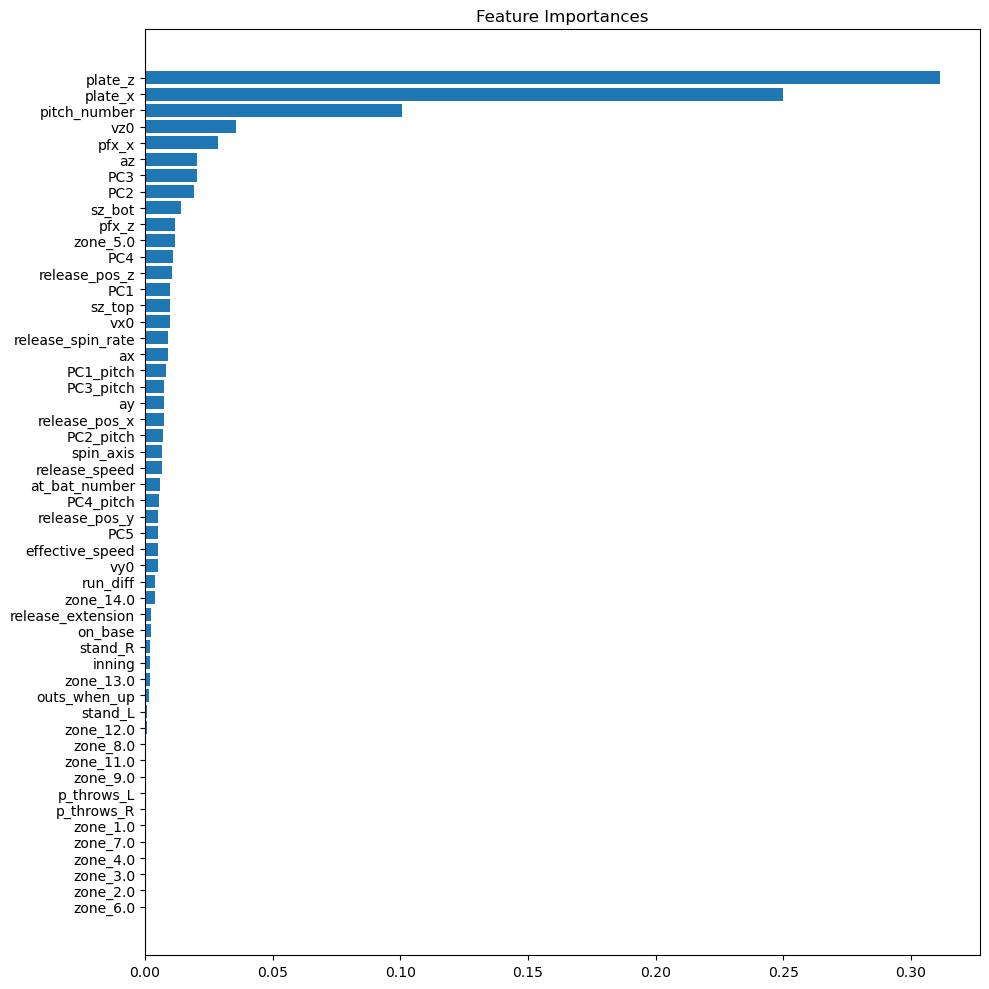

In [135]:
feature_importances = clf.feature_importances_
sorted_idx = feature_importances.argsort()
feature_names = X_train_dt.columns

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

### random forest

Random forest is an ensemble method that combines many decision trees. Each tree is constructed using a random subset of the data set. This introduces variability within each tree which reduces the risk of overfitting. As with decision trees we need to tune the best depth, however there are also a number of other hyperparameters we can tune including how many trees are fitted (n_estimators), and the minimum number of samples a node can be split and remain in a leaf node. 

We can tune these hyperparameters using a simple grid search method available from sklearn. 

In [137]:
from sklearn import  ensemble


In [141]:
##grid search 

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the model
rf = ensemble.RandomForestClassifier(random_state=42, max_features = 'sqrt')

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_dt, y_train)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


This grid search doesn't provide all possible combinations as the number of permutations would be too large however it gives a good idea of the hyperparameters that can then be fine tuned.

The data is fitted to the model using the best hyperparameters from the grid search 

In [176]:

rf_clf = ensemble.RandomForestClassifier(max_depth = 30, max_features = 'sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=400)
rf_clf.fit(X_train_dt, y_train)

print ( 'training accuracy ',rf_clf.score(X_train_dt, y_train), 'validation accuracy', rf_clf.score(X_val_dt, y_val))

y_pred = rf_clf.predict(X_val_dt)

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

training accuracy  0.9979501122043846 validation accuracy 0.5102925945106163
Confusion Matrix:
 [[7499  387 1302  139   29]
 [ 471 5960  542  918 1364]
 [1976 1230 3794  975 1332]
 [ 725 1885 1223 2376 3044]
 [ 402 2007  907 1837 4020]]


accuracy of specific classes (sensitivity): balls: 0.802 strikes: 0.644 swinging strikes: 0.408 Weak contact: 0.257 Solid contact: 0.438


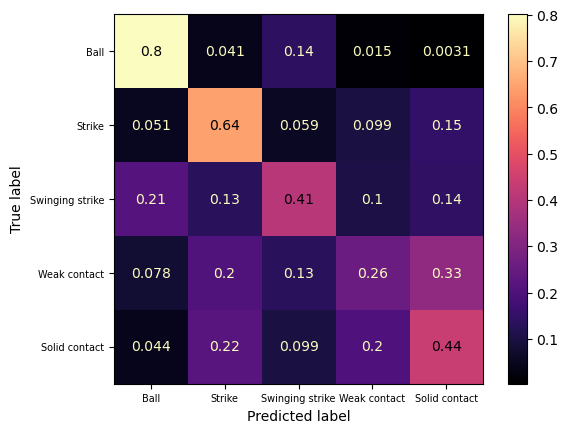

In [177]:

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmd = ConfusionMatrixDisplay(cmn, display_labels=["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"])
cmd.plot(cmap="magma")
plt.xticks(fontsize=7)  # Reduce font size for x-axis labels
plt.yticks(fontsize=7)

acc_ball =cm[0,0] / sum(cm[0,:]) 
acc_strike = cm[1,1] / sum(cm[1,:]) 
acc_sw_strike = cm[2,2] / sum(cm[2,:]) 
acc_weak =cm[3,3] / sum(cm[3,:]) 
acc_solid =cm[4,4] / sum(cm[4,:]) 

print("accuracy of specific classes (sensitivity):","balls:",round(acc_ball,3), "strikes:", round(acc_strike,3), "swinging strikes:", 
      round(acc_sw_strike,3), "Weak contact:",round(acc_weak,3), "Solid contact:", round(acc_solid,3))



The model shows a much better accuracy than decision trees. Balls particularly have a high accuracy at 80%. Weak contact has the poorest accuracy, only slighty better than chance.

In [178]:
#save results of classification for model comparison
report_rf = classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"],
                           output_dict = True)
print(classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"]))

                 precision    recall  f1-score   support

           Ball       0.68      0.80      0.73      9356
         Strike       0.52      0.64      0.58      9255
Swinging strike       0.49      0.41      0.44      9307
   Weak contact       0.38      0.26      0.31      9253
  Solid contact       0.41      0.44      0.42      9173

       accuracy                           0.51     46344
      macro avg       0.50      0.51      0.50     46344
   weighted avg       0.50      0.51      0.50     46344



### Neural network

We will be fitting a simple Multilayer Perceptron network, which is a type of feedforward neural network consisting of an inputer layer, or one more hidden layers, and an output layer. The advantage of this approach is we can output probabilities of class predictions using a softmax activation function. Neural networks will be fitted using the tensorflow package.

There are many hyperparameters that require tuning for a neural network - this will be done using the hyperparameter optimisation package optuna. Optuna uses bayesian optimisation to search the hyperparameter space and find the optimal combination. 


Before fitting a model, the principal components are removed from the data - this is because the network learns from all the nuanced patterns in the data therefore we do not want to throw away any variance. 

In [145]:
cols_drop = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC1_pitch', 'PC2_pitch', 'PC3_pitch', 'PC4_pitch']


X_train_net = X_train.drop(labels=cols_drop,axis=1)
X_train_net = X_train_net.apply(pd.to_numeric, errors='coerce')
X_train_net = np.array(X_train_net, dtype=np.float32)

y_train_net = y_train.apply(pd.to_numeric, errors='coerce')
y_train_net = np.array(y_train_net, dtype=np.float32)

X_val_net = X_val.drop(labels=cols_drop,axis=1)
X_val_net = X_val_net.apply(pd.to_numeric, errors='coerce')
X_val_net = np.array(X_val_net, dtype=np.float32)

y_val_net = y_val.apply(pd.to_numeric, errors='coerce')
y_val_net = np.array(y_val_net, dtype=np.float32)




All data is converted to numeric and scaled to ensure data is comparable. This was not neccessary for the previous models as decision trees cope well with categorical and unscaled data since it's only ever looking at one variable at a time. 

In [146]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_net)
X_train_net = scaling.transform(X_train_net)
X_val_net = scaling.transform(X_val_net)

In [147]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from optuna.integration import KerasPruningCallback

The first step is to conduct a high level optimisation for the number of hidden layers. Ideally it would be best to include all hyperparameters in the optimisation as some hyperparameters will be dependant on one another, however this is to get an inital idea of the network architecture.

The loss function is sparse categorical crossentropy which is most suited for multi-class problems 

the traditional optimisation algorithm to minimize the loss function would be to use stochastic gradient descent (SGD). However Adam (Adaptive Moment Estimation) is more readily used. Adam is an optimizer that combines momentum and adaptive learning rates to adjust the step size for each parameter dynamically, making it efficient and robust in handling noisy gradients and complex datasets. In contrast, SGD (Stochastic Gradient Descent) uses a fixed global learning rate to update parameters based on the gradient, which can be slower and requires careful tuning. We're using Adam instead of SGD because it converges faster, requires less manual tuning, and performs better in high-dimensional and noisy optimization problems.

In [191]:
### number of layers optimisation 


# Assuming X_train is defined
input_dim = X_train_net.shape[1]
output_dim = len(set(y_train_net))  # Number of classes (for classification)


# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    num_layers = trial.suggest_int("num_layers", 1, 5)  # Number of layers
    units_per_layer = trial.suggest_int("units_per_layer", 10, 100)  # Neurons per layer
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # Learning rate
    #activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'softplus'])

    # Build the model dynamically
    model = Sequential([Input(shape=(input_dim,))])
    model.add(Dense(units_per_layer, activation='relu', ))
    for _ in range(num_layers - 1):
        model.add(Dense(units_per_layer, activation='relu'))
    model.add(Dense(output_dim, activation="softmax"))  # Output layer for binary classification

    # Define pruning callback for Keras
    #pruning_callback = KerasPruningCallback(trial, 'val_loss')
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_net, y_train_net, 
                        validation_data=(X_val_net, y_val_net),
                        epochs=25, 
                        batch_size=80, 
                        verbose=0#,callbacks=[pruning_callback]
                       )
    
    # Return validation accuracy
    val_acc = max(history.history['val_accuracy'])
    return val_acc
    

study = optuna.create_study(direction='maximize', study_name = "nn_layerOpt", )
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)

[I 2024-11-25 18:31:40,051] A new study created in memory with name: nn_layerOpt
[I 2024-11-25 18:32:16,489] Trial 0 finished with value: 0.5337907671928406 and parameters: {'num_layers': 5, 'units_per_layer': 31, 'learning_rate': 0.0012072572492000278}. Best is trial 0 with value: 0.5337907671928406.
[I 2024-11-25 18:32:46,530] Trial 1 finished with value: 0.40041860938072205 and parameters: {'num_layers': 2, 'units_per_layer': 14, 'learning_rate': 1.0820887933617454e-05}. Best is trial 0 with value: 0.5337907671928406.
[I 2024-11-25 18:33:21,553] Trial 2 finished with value: 0.5313740968704224 and parameters: {'num_layers': 5, 'units_per_layer': 17, 'learning_rate': 0.0013531656895977035}. Best is trial 0 with value: 0.5337907671928406.
[I 2024-11-25 18:33:58,505] Trial 3 finished with value: 0.49169257283210754 and parameters: {'num_layers': 4, 'units_per_layer': 53, 'learning_rate': 4.1197642108491376e-05}. Best is trial 0 with value: 0.5337907671928406.
[I 2024-11-25 18:34:36,533]

Best hyperparameters: {'num_layers': 4, 'units_per_layer': 65, 'learning_rate': 0.0005004045944017631}


After 100 trials, the optimum number of layers are 4 with an accuracy of 0.543, though 3 and 5 layers perfomed well (~0.536). The optimisation had to restarted a few times as it would get stuck in a local optimum at around .49 accuracy. 

The next step is to run another optimisation, this was intially tried with three layers and then with four. The outputs are not all included in this notebook as they are very lengthy however the code has been provided as well as the final results

In [ ]:
# 4 layer hyperparameter optimisation


input_dim = X_train_net.shape[1]
output_dim = len(set(y_train_net))  # Number of classes (for classification)

def objective(trial):
    # Define hyperparameters
    num_neurons1 = trial.suggest_int('num_neurons1', 10, 100)
    num_neurons2 = trial.suggest_int('num_neurons2', 10, 100)
    num_neurons3 = trial.suggest_int('num_neurons3', 10, 100)
    num_neurons4 = trial.suggest_int('num_neurons3', 10, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    learning_rate = learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-5, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)
    epochs = trial.suggest_int('epochs', 10, 50)


    
    # Build the model
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(num_neurons1, activation="relu"),
        Dropout(dropout_rate),
        Dense(num_neurons2, activation="relu"),
        Dropout(dropout_rate),
        Dense(num_neurons3, activation="relu"),
        Dropout(dropout_rate),
        Dense(num_neurons4, activation="relu"),
        Dropout(dropout_rate),
        Dense(output_dim, activation='softmax')
    ])
    
    # Define pruning callback for Keras
   #pruning_callback = KerasPruningCallback(trial, 'val_loss', interval = 5)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_net, y_train_net, 
                        validation_data=(X_val_net, y_val_net),
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=0)
    
    # Return validation accuracy
    val_acc = max(history.history['val_accuracy'])
    return val_acc
    

study = optuna.create_study(direction='maximize', study_name="nn3_t1")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best hyperparameters:", study.best_value)


In [192]:
# 3 layer hyperparameter optimisation


input_dim = X_train_net.shape[1]
output_dim = len(set(y_train_net))  # Number of classes (for classification)

#round 2 adjusting HP space
def objective(trial):
    # Define hyperparameters
    num_neurons1 = trial.suggest_int('num_neurons1', 10, 100)
    num_neurons2 = trial.suggest_int('num_neurons2', 10, 100)
    num_neurons3 = trial.suggest_int('num_neurons3', 10, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    learning_rate = learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-5, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)
    epochs = trial.suggest_int('epochs', 10, 50)


    
    # Build the model
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(num_neurons1, activation="relu"),
        Dropout(dropout_rate),
        Dense(num_neurons2, activation="relu"),
        Dropout(dropout_rate),
        Dense(num_neurons3, activation="relu"),
        Dropout(dropout_rate),
        Dense(output_dim, activation='softmax')
    ])
    
    # Define pruning callback for Keras
   #pruning_callback = KerasPruningCallback(trial, 'val_loss', interval = 5)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_net, y_train_net, 
                        validation_data=(X_val_net, y_val_net),
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=0)
    
    # Return validation accuracy
    val_acc = max(history.history['val_accuracy'])
    return val_acc
    

study = optuna.create_study(direction='maximize', study_name="nn3_t2")
study.optimize(objective, n_trials=25)

print("Best hyperparameters:", study.best_params)
print("Best hyperparameters:", study.best_value)


[I 2024-11-25 19:52:05,289] A new study created in memory with name: nn3_t2
[I 2024-11-25 19:53:43,610] Trial 0 finished with value: 0.5380415916442871 and parameters: {'num_neurons1': 50, 'num_neurons2': 26, 'num_neurons3': 51, 'dropout_rate': 0.0500661182916041, 'learning_rate': 0.00041568677309282713, 'weight_decay': 3.867327967030458e-08, 'batch_size': 64, 'epochs': 50}. Best is trial 0 with value: 0.5380415916442871.
[I 2024-11-25 19:54:40,883] Trial 1 finished with value: 0.5314388275146484 and parameters: {'num_neurons1': 62, 'num_neurons2': 89, 'num_neurons3': 84, 'dropout_rate': 0.06864991076275398, 'learning_rate': 0.003380548533624348, 'weight_decay': 3.141587985457182e-08, 'batch_size': 64, 'epochs': 27}. Best is trial 0 with value: 0.5380415916442871.
[I 2024-11-25 19:54:58,888] Trial 2 finished with value: 0.4747108519077301 and parameters: {'num_neurons1': 88, 'num_neurons2': 80, 'num_neurons3': 85, 'dropout_rate': 0.04540344131682923, 'learning_rate': 5.6255191261170146

Best hyperparameters: {'num_neurons1': 74, 'num_neurons2': 65, 'num_neurons3': 48, 'dropout_rate': 0.042956492192100126, 'learning_rate': 0.0012903178478699496, 'weight_decay': 3.93065217070349e-09, 'batch_size': 80, 'epochs': 34}
Best hyperparameters: 0.5386673808097839


The final results from the optimisation are as follows:

3-layer 

    Best hyperparameters: {'num_neurons1': 80, 'num_neurons2': 75, 'num_neurons3': 53, 'dropout_rate': 0.029356214847522537, 'learning_rate': 0.00018021609425499215, 'weight_decay': 1.9638285494862782e-08, 'batch_size': 72, 'epochs': 76}
    
    Best accuracy: 0.5419    

4-layer 

    Best hyperparameters: {'num_neurons1': 59, 'num_neurons2': 73, 'num_neurons3': 35, 'num_neurons4': 52, 'dropout_rate': 0.018800058995185845, 'learning_rate': 0.0003577109063219717, 'weight_decay': 2.2677480508937757e-08, 'batch_size': 112, 'epochs': 6
     
    Best accuracy:  0.5411


since accuracy is not the sole measure of success, both a 3-layer and 4-layer architectures weres trained and results compared on the validation set. 



#### 3-layer final model

In [289]:
#3 layer final model 

input_dim = X_train_net.shape[1]
output_dim = len(set(y_train_net))  # Number of classes (for classification)
drop_out =  0.029356214847522537
lr =0.00018021609425499215
wd = 1.9638285494862782e-08
batch = 72

    
# Build the model
model_3l = Sequential([
    Input(shape=(input_dim,)),
    Dense(80, activation="relu"),
    Dropout(drop_out),
    Dense(75, activation="relu"),
    Dropout(drop_out),
    Dense(53, activation="relu"),
    Dropout(drop_out),
    Dense(output_dim, activation='softmax')
])
    
# Compile the model
model_3l.compile(optimizer=Adam(learning_rate=lr, weight_decay=wd),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_3l.fit(X_train_net, y_train_net, 
                    validation_data=(X_val_net, y_val_net),
                    epochs=70, 
                    batch_size=batch, 
                    verbose=1)

val_acc = max(history.history['val_accuracy'])
print(val_acc)




Epoch 1/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3486 - loss: 1.4506 - val_accuracy: 0.4449 - val_loss: 1.2880
Epoch 2/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - accuracy: 0.4410 - loss: 1.2873 - val_accuracy: 0.4612 - val_loss: 1.2527
Epoch 3/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - accuracy: 0.4540 - loss: 1.2589 - val_accuracy: 0.4738 - val_loss: 1.2214
Epoch 4/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - accuracy: 0.4690 - loss: 1.2253 - val_accuracy: 0.4833 - val_loss: 1.1931
Epoch 5/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - accuracy: 0.4777 - loss: 1.2024 - val_accuracy: 0.4902 - val_loss: 1.1719
Epoch 6/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - accuracy: 0.4870 - loss: 1.1822 - val_accuracy: 0.4936 - val_loss: 1.1601
Epoch 7/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step - accuracy: 0.4938 - loss: 1.1628 - val_accuracy: 0.5028 - val_loss: 1.1479
Epoch 8/70
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 943us/step - accuracy: 0.4982 - l

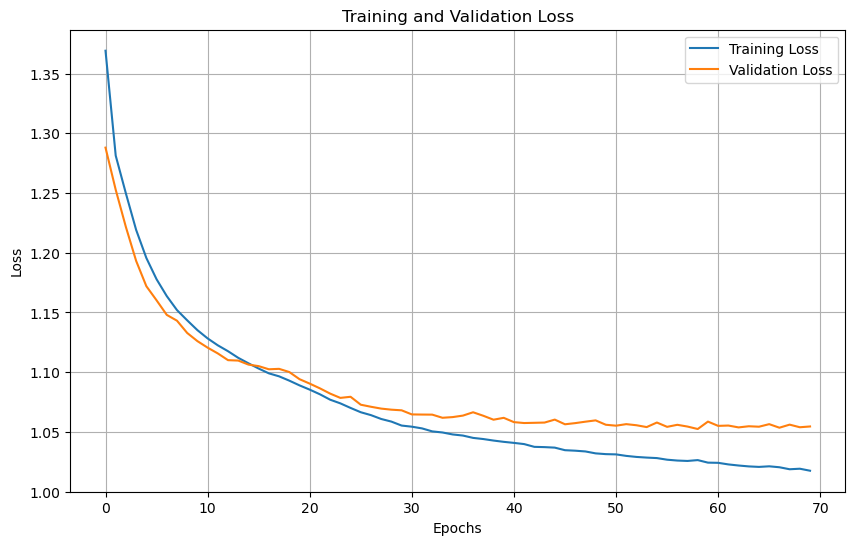

In [290]:
# Step 5: Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


training accuracy: 0.5581520795822144 validation accuracy: 0.541774570941925
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Ball'),
  Text(0, 1, 'Strike'),
  Text(0, 2, 'Swinging strike'),
  Text(0, 3, 'Weak contact'),
  Text(0, 4, 'Solid contact')])

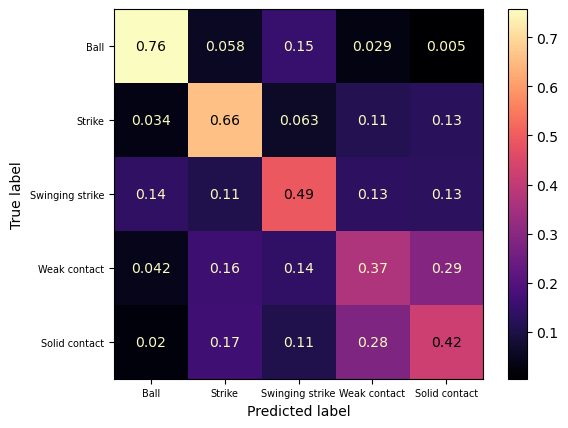

In [291]:
train_acc = max(history.history['accuracy'])
val_acc = max(history.history['val_accuracy'])
print("training accuracy:" , train_acc, "validation accuracy:", val_acc)

# Prediction probabilites for validation data
probabilities_3l = model_3l.predict(X_val_net)

y_pred = np.argmax(probabilities_3l, axis=1)
# Generate the confusion matrix
cm_nn3l = confusion_matrix(y_val, y_pred)
cmn = cm_nn3l.astype('float') / cm_nn3l.sum(axis=1)[:, np.newaxis]
cmd = ConfusionMatrixDisplay(cmn, display_labels=["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"])
cmd.plot(cmap="magma")
plt.xticks(fontsize=7)  # Reduce font size for x-axis labels
plt.yticks(fontsize=7)



#### 4-layer final model

Epoch 1/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3545 - loss: 1.4274 - val_accuracy: 0.4543 - val_loss: 1.2655
Epoch 2/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4508 - loss: 1.2650 - val_accuracy: 0.4709 - val_loss: 1.2186
Epoch 3/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4711 - loss: 1.2199 - val_accuracy: 0.4827 - val_loss: 1.1834
Epoch 4/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4813 - loss: 1.1916 - val_accuracy: 0.4941 - val_loss: 1.1607
Epoch 5/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4896 - loss: 1.1675 - val_accuracy: 0.4962 - val_loss: 1.1512
Epoch 6/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4971 - loss: 1.1521 - val_accuracy: 0.5029 - val_loss: 1.1390
Epoch 7/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4975 - loss: 1.1457 - val_accuracy: 0.5028 - val_loss: 1.1330
Epoch 8/69
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5037 - loss: 1.1342 - 

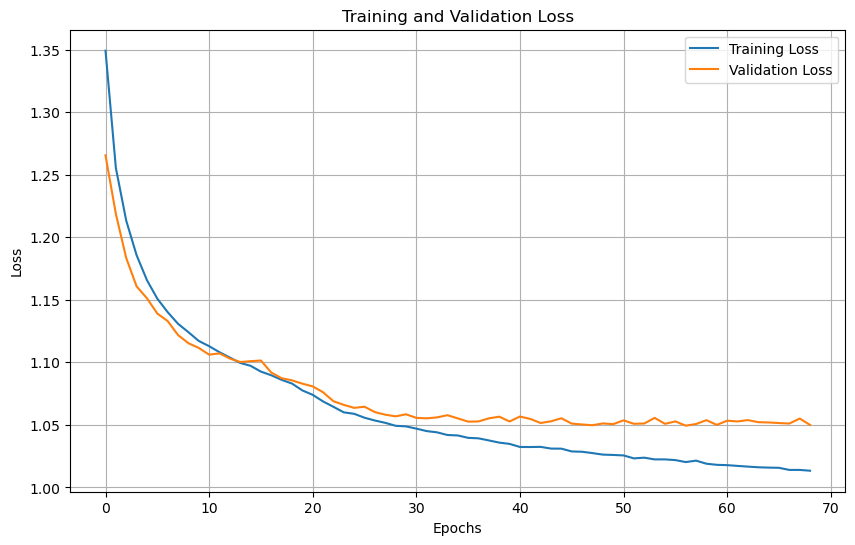

In [157]:
#4-layer final model

input_dim = X_train_net.shape[1]
output_dim = len(set(y_train_net))  # Number of classes (for classification)
drop_out = 0.018800058995185845
lr =0.0003577109063219717
wd = 2.2677480508937757e-08
batch = 112

    
# Build the model
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(59, activation="relu"),
    Dropout(drop_out),
    Dense(73, activation="relu"),
    Dropout(drop_out),
    Dense(35, activation="relu"),
    Dropout(drop_out),
    Dense(52, activation="relu"),
    Dropout(drop_out),
    Dense(output_dim, activation='softmax')
])
    
# Compile the model
model.compile(optimizer=Adam(learning_rate=lr, weight_decay=wd),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_net, y_train_net, 
                    validation_data=(X_val_net, y_val_net),
                    epochs=69, 
                    batch_size=batch, 
                    verbose=1)

val_acc = max(history.history['val_accuracy'])
print(val_acc)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()



In [163]:
train_acc = max(history.history['accuracy'])
val_acc = max(history.history['val_accuracy'])
print("training accuracy:" , train_acc, "validation accuracy:", val_acc)

# Prediction probabilites for validation data
probabilities = model.predict(X_val_net)


training accuracy: 0.5585692524909973 validation accuracy: 0.5418608784675598
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step


accuracy of specific classes (sensitivity): balls: 0.761 strikes: 0.641 swinging strikes: 0.491 Weak contact: 0.384 Solid contact: 0.419


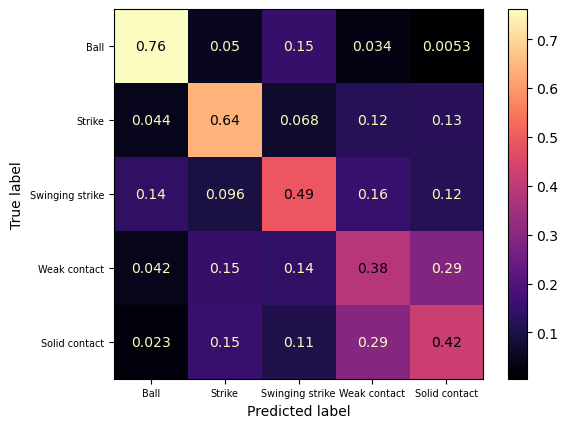

In [263]:
y_pred = np.argmax(probabilities, axis=1)
# Generate the confusion matrix
cm_nn = confusion_matrix(y_val, y_pred)
cmn = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
cmd = ConfusionMatrixDisplay(cmn, display_labels=["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"])
cmd.plot(cmap="magma")
plt.xticks(fontsize=7)  # Reduce font size for x-axis labels
plt.yticks(fontsize=7)

acc_ball =cm_nn[0,0] / sum(cm_nn[0,:]) 
acc_strike = cm_nn[1,1] / sum(cm_nn[1,:]) 
acc_sw_strike = cm_nn[2,2] / sum(cm_nn[2,:]) 
acc_weak =cm_nn[3,3] / sum(cm_nn[3,:]) 
acc_solid =cm_nn[4,4] / sum(cm_nn[4,:]) 

print("accuracy of specific classes (sensitivity):","balls:",round(acc_ball,3), "strikes:", round(acc_strike,3), "swinging strikes:", 
      round(acc_sw_strike,3), "Weak contact:",round(acc_weak,3), "Solid contact:", round(acc_solid,3))



Of the two types of architectures (3-layer and 4-layer), they performed very similarly with a 54% overall accuracy. The 4-layer model was slightly better at classifying 'weak contact' which has been a struggle for other models therefore that model was chosen. 

In [160]:
#save the model 
model.save('model_nn_4lyr_v1.keras') 

In [161]:
#save results of classification for model comparison
report_nn = classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"],
                           output_dict = True)
print(classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"]))

                 precision    recall  f1-score   support

           Ball       0.76      0.76      0.76      9356
         Strike       0.59      0.64      0.61      9255
Swinging strike       0.51      0.49      0.50      9307
   Weak contact       0.39      0.38      0.39      9253
  Solid contact       0.44      0.42      0.43      9173

       accuracy                           0.54     46344
      macro avg       0.54      0.54      0.54     46344
   weighted avg       0.54      0.54      0.54     46344



We can also plot the distribution of predicted probabilities for each class

In [ ]:
y_act = pd.Series(y_val, name = "y_actual")
temp = pd.concat([X_val, y_act], axis = 1)
temp[["prob_Ball", "prob_CStrike", "prob_SWStrike", "prob_weak", "prob_solid"]] = probabilities
temp



In [375]:
# Get the predicted class by taking the class with the highest probability
temp["y_pred"] = probabilities.argmax(axis=1)

temp["max_prob"] = temp[["prob_Ball","prob_CStrike", "prob_SWStrike","prob_weak","prob_solid"]].max(axis=1)


In [376]:
temp.groupby("y_pred")["max_prob"].mean()

y_pred
0    0.767820
1    0.575904
2    0.518840
3    0.425874
4    0.434593
Name: max_prob, dtype: float32

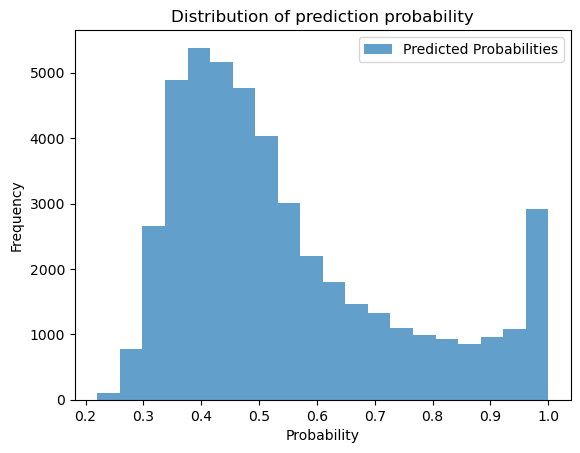

In [377]:
plt.hist(temp["max_prob"], bins=20, alpha=0.7, label="Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Distribution of prediction probability")
plt.legend()
plt.show()

The historgram shows that the majority of predictions the probability of being predicted that class was fairly low at around 40%. However there is also a high proportion (around 3000 cases) where there was almost 100% probability of being predicted a given class. Looking at the mean by class, we can see prediction probabilities are much high for Balls (76%) than any other class

### XGBoost

The fourth model is XGBoost (eXtreme Gradient Boosting). It uses ensemble learning techniques that combine the predictions of multiple weak learners. It optimizes a differentiable loss function (e.g., logistic loss) via gradient descent by repeatedly changing the model’s parameters in response to the gradients of the errors. 



In [166]:
from xgboost import XGBClassifier

As with decision trees and random forest, we are dropping columns that are included in the PCA. 

In [168]:
cols_drop = ['k_percent','bb_percent', 'xba', 'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent',
       'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent',
       'hard_hit_percent', 'avg_hyper_speed', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'iz_contact_percent', 'xhr_rate', 'k_percent_pitch', 'bb_percent_pitch', 'xba_pitch',
       'xslg_pitch', 'xwoba_pitch', 'xwobacon_pitch',
       'sweet_spot_percent_pitch', 'barrel_batted_rate_pitch',
       'solidcontact_percent_pitch', 'flareburner_percent_pitch',
       'poorlyunder_percent_pitch', 'poorlytopped_percent_pitch',
       'poorlyweak_percent_pitch', 'hard_hit_percent_pitch',
       'avg_hyper_speed_pitch', 'z_swing_percent_pitch',
       'z_swing_miss_percent_pitch', 'oz_swing_percent_pitch',
       'oz_swing_miss_percent_pitch', 'xhr_rate_pitch']


X_train_xgb = X_train.drop(labels=cols_drop,axis=1)
X_val_xgb = X_val.drop(labels=cols_drop,axis=1)


As with neural networks, we tune the hyperparameters using optuna. Hyperparmetes include, similar to decision trees and random forest, the max depth and number of trees(n_estimators), as well as learning rate etc.

In [220]:
def objective(trial):
    # Define hyperparameters to tune
    param = {
        'objective': 'multi:softmax',  # Multi-class classification
        'num_class': 5,                # Number of classes 
        'eval_metric': 'mlogloss',       # Evaluation metric (multi-class error rate)
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1 ,log=True),  
        'max_depth': trial.suggest_int('max_depth', 3, 10),  
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  
        'gamma': trial.suggest_float('gamma', 0, 5),  # Regularization term for splitting
        'alpha': trial.suggest_float('alpha', 0, 1),  # L1 regularization term
        'lambda': trial.suggest_float('lambda', 0, 1),  # L2 regularization term
    }

     # Get n_estimators directly
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)

        # Create and train the model
    model = xgb.XGBClassifier(**param, n_estimators=n_estimators, early_stopping_rounds=50)

    # Train the model with early stopping
    model.fit(X_train_xgb, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Get the best iteration (number of boosting rounds)
    best_iteration = model.best_iteration

    # Return the accuracy score (or other evaluation metric)
    y_pred = model.predict(X_val_xgb, iteration_range=(0, best_iteration))
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Create a study to optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy

# Run the optimization for a certain number of trials
study.optimize(objective, n_trials=50)  # You can increase this number for better results



[I 2024-11-25 21:50:12,371] A new study created in memory with name: no-name-3477a54b-ce36-4053-9362-0a5b063e561c
[I 2024-11-25 21:50:39,939] Trial 0 finished with value: 0.5185137234593475 and parameters: {'learning_rate': 0.01780363693107737, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5328869393706629, 'colsample_bytree': 0.6645775711614054, 'gamma': 2.360972204201794, 'alpha': 0.5164580919401798, 'lambda': 0.7297280122133185, 'n_estimators': 441}. Best is trial 0 with value: 0.5185137234593475.
[I 2024-11-25 21:50:47,954] Trial 1 finished with value: 0.45438460210598997 and parameters: {'learning_rate': 0.0005687687939514216, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9806643794065849, 'colsample_bytree': 0.7532637474738301, 'gamma': 4.38127641403815, 'alpha': 0.12393657916424827, 'lambda': 0.7008624484212468, 'n_estimators': 152}. Best is trial 0 with value: 0.5185137234593475.
[I 2024-11-25 21:51:57,043] Trial 2 finished with value: 0.4957707578111514 and par

In [222]:
#study = optuna.load_study(study_name="nn3_t1", storage="sqlite:///example.db")
study.optimize(objective, n_trials=50)  # Add 10 more trials
print("Best hyperparameters:", study.best_params)
print("Best hyperparameters:", study.best_value)

[I 2024-11-25 22:39:26,816] Trial 50 finished with value: 0.5455506645952011 and parameters: {'learning_rate': 0.09911206689313397, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7822503963438168, 'colsample_bytree': 0.6889604904912869, 'gamma': 0.47311006851969073, 'alpha': 0.5250542821745705, 'lambda': 0.7973906388070032, 'n_estimators': 746}. Best is trial 50 with value: 0.5455506645952011.
[I 2024-11-25 22:40:08,735] Trial 51 finished with value: 0.5458743310892457 and parameters: {'learning_rate': 0.07805552724707418, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7822368034482599, 'colsample_bytree': 0.7378341014211517, 'gamma': 0.5962335251954749, 'alpha': 0.5448136421387555, 'lambda': 0.8425608338666055, 'n_estimators': 772}. Best is trial 51 with value: 0.5458743310892457.
[I 2024-11-25 22:40:50,522] Trial 52 finished with value: 0.5463490419471776 and parameters: {'learning_rate': 0.08524365286111116, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7926813

Best hyperparameters: {'learning_rate': 0.056423949275802236, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9030857614474859, 'colsample_bytree': 0.9103628706271728, 'gamma': 0.3919908787189251, 'alpha': 0.8340000252468052, 'lambda': 0.4252149822063047, 'n_estimators': 865}
Best hyperparameters: 0.5504056620058692


In [223]:
#study = optuna.load_study(study_name="nn3_t1", storage="sqlite:///example.db")
study.optimize(objective, n_trials=20)  # Add 10 more trials
print("Best hyperparameters:", study.best_params)
print("Best hyperparameters:", study.best_value)

[I 2024-11-26 00:02:24,252] Trial 100 finished with value: 0.5535775936475056 and parameters: {'learning_rate': 0.05760314577998276, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.946806546203631, 'colsample_bytree': 0.9110794771805208, 'gamma': 0.18424330019055168, 'alpha': 0.8254441970470365, 'lambda': 0.5448937149455012, 'n_estimators': 839}. Best is trial 100 with value: 0.5535775936475056.
[I 2024-11-26 00:03:22,495] Trial 101 finished with value: 0.5508156395649922 and parameters: {'learning_rate': 0.059604692420492614, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9641604327749362, 'colsample_bytree': 0.9185701428921496, 'gamma': 0.22995838249010997, 'alpha': 0.8220345894886666, 'lambda': 0.43716896975618963, 'n_estimators': 837}. Best is trial 100 with value: 0.5535775936475056.
[I 2024-11-26 00:04:20,317] Trial 102 finished with value: 0.5518082168133954 and parameters: {'learning_rate': 0.061171939695914446, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0

Best hyperparameters: {'learning_rate': 0.06273605155285643, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9464581164650249, 'colsample_bytree': 0.9914516116195514, 'gamma': 0.5347098534825147, 'alpha': 0.9938464790576143, 'lambda': 0.43911788440425054, 'n_estimators': 944}
Best hyperparameters: 0.5543759709994821


The final best hyperparameters where: 

    {'learning_rate': 0.06273605155285643, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9464581164650249, 'colsample_bytree': 0.9914516116195514, 'gamma': 0.5347098534825147, 'alpha': 0.9938464790576143, 'lambda': 0.43911788440425054, 'n_estimators': 944} 
    
    Best accuracy: 0.5543759709994821

the XGB model is fitted to the data using these hyperparameters. Upon fitting the model, the performance was improved without l2 regularisation (lambda) therefore this was removed in the final model

In [292]:
# Final model 

# Create the model
model_xgb =XGBClassifier(
    seed=42,
    objective='multi:softprob',  # Softmax for multi-class classification
    num_class=5,                # Number of classes
    eval_metric='mlogloss',     # Log-loss for multi-class
    learning_rate=0.06273605155285643,          # Learning rate
    max_depth=8, 
    min_child_weight = 5,
    colsample_bytree=0.9914516116195514,
    subsample=0.9464581164650249,
    n_estimators=944,
    gamma = 0.5347098534825147,
    alpha =0.9938464790576143
    #reg_lambda = 0.43911788440425054, #model performance was improved without this parameter
   
)

# Fit the model with early stopping
model_xgb.fit(
    X_train_xgb, y_train,
    eval_set=[(X_val_xgb, y_val)],  # Validation data
    verbose=False              # Enable verbose logs
)

# Predict and evaluate
y_pred = model_xgb.predict(X_val_xgb)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 0.5515


In [293]:
# Predict probabilities for all classes
y_pred_probs = model_xgb.predict_proba(X_val_xgb)



accuracy of specific classes (sensitivity): balls: 0.784 strikes: 0.688 swinging strikes: 0.496 Weak contact: 0.323 Solid contact: 0.463


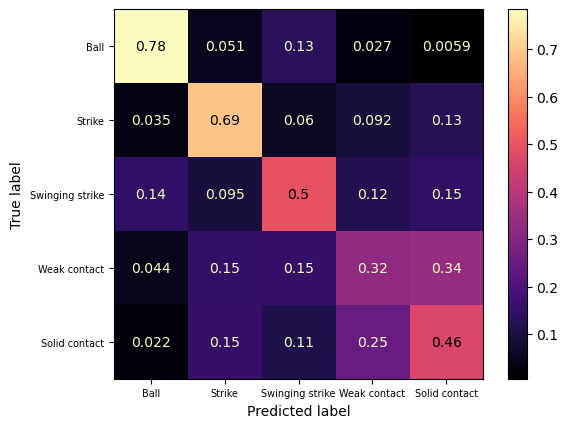

In [294]:

# Generate the confusion matrix
cm_xgb = confusion_matrix(y_val, y_pred)
cmn = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]
cmd = ConfusionMatrixDisplay(cmn, display_labels=["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"])
cmd.plot(cmap="magma")
plt.xticks(fontsize=7)  # Reduce font size for x-axis labels
plt.yticks(fontsize=7)

acc_ball =cm_xgb[0,0] / sum(cm_xgb[0,:]) 
acc_strike = cm_xgb[1,1] / sum(cm_xgb[1,:]) 
acc_sw_strike = cm_xgb[2,2] / sum(cm_xgb[2,:]) 
acc_weak =cm_xgb[3,3] / sum(cm_xgb[3,:]) 
acc_solid =cm_xgb[4,4] / sum(cm_xgb[4,:]) 

print("accuracy of specific classes (sensitivity):","balls:",round(acc_ball,3), "strikes:", round(acc_strike,3), "swinging strikes:", 
      round(acc_sw_strike,3), "Weak contact:",round(acc_weak,3), "Solid contact:", round(acc_solid,3))



In [295]:
#save model for later use
model_xgb.save_model("model_xgb_v2.json") 

In [296]:
#save results of classification for model comparison
report_xgb = classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"],
                           output_dict = True)
print(classification_report(y_val, y_pred, target_names =["Ball", "Strike", "Swinging strike", "Weak contact", "Solid contact"]))

                 precision    recall  f1-score   support

           Ball       0.76      0.78      0.77      9356
         Strike       0.61      0.69      0.65      9255
Swinging strike       0.52      0.50      0.51      9307
   Weak contact       0.40      0.32      0.36      9253
  Solid contact       0.43      0.46      0.44      9173

       accuracy                           0.55     46344
      macro avg       0.54      0.55      0.55     46344
   weighted avg       0.54      0.55      0.55     46344



## Model comparison 


In [297]:
#Overall accuracy 

models_acc = {"decision_tree": report_dt["accuracy"], "random_forest":report_rf["accuracy"], "XGBoost":report_xgb["accuracy"], 
              "neural_network": report_nn["accuracy"]}
models_acc

{'decision_tree': 0.46025375453133094,
 'random_forest': 0.5102925945106163,
 'XGBoost': 0.551484550319351,
 'neural_network': 0.5398325565337476}

Overall, XGBoost had the highest accuracy at 55%, however neural networks were very similar at 54%. In terms of how successful the model is for each of the classes we can compare the sensitivity or recall rates of each class (i.e. of each class how many were correctly predicted)

In [298]:
# First convert the classification reports into a data frame
scores_dt = pd.DataFrame(report_dt).T 
scores_dt['model'] = "decision tree"

scores_rf = pd.DataFrame(report_rf).T 
scores_rf['model'] = "random forest"

scores_xgb = pd.DataFrame(report_xgb).T 
scores_xgb['model'] = "XGBoost"

scores_nn = pd.DataFrame(report_nn).T 
scores_nn['model'] = "neural network"

fin_scores = pd.concat([scores_dt, scores_rf, scores_xgb,scores_nn], axis = 0)

fin_scores = fin_scores.drop(labels="support",axis=1)
fin_scores = fin_scores.drop(labels=["accuracy", "macro avg", "weighted avg"],axis=0)

In [299]:
fin_scores.loc[:,["recall", "model"]]

recall           model
Ball             0.650812   decision tree
Strike           0.597623   decision tree
Swinging strike  0.362630   decision tree
Weak contact     0.219280   decision tree
Solid contact    0.469421   decision tree
Ball             0.801518   random forest
Strike           0.643976   random forest
Swinging strike  0.407650   random forest
Weak contact     0.256782   random forest
Solid contact    0.438243   random forest
Ball             0.784096         XGBoost
Strike           0.687736         XGBoost
Swinging strike  0.496401         XGBoost
Weak contact     0.322922         XGBoost
Solid contact    0.463207         XGBoost
Ball             0.761437  neural network
Strike           0.640843  neural network
Swinging strike  0.490598  neural network
Weak contact     0.384092  neural network
Solid contact    0.418947  neural network

**Comparison of sensitivity of each class**

Ball  - random forest has the highest accuracy at 80%, decision trees have the lowest at 65%

Called Strike -XGBoost has the highest accuracy at 69%

Swinging Strike - XGBoost and neural network have a similar accuracy at 49%-50%

Weak contact - this class appeared to be the most difficult to classify. Neural network had the best accuracy at 38%

Solid contact - Interestingly decision trees had the best accuracy despite underperforming in all other classes, though XGBoost was very similar.




Coupled with the overall accuracy scores, XGBoost performs the best. However, model selection depends on the needs and intended use. Whilst overall accuracy is important, in terms of baseball managerial decision the key factors are:

1. what pitcher is most likely to strike out a batter (either called or swinging)
2. What batter is likely to get a hit of a given pitcher, and get a good hit?

As the classes are balanced we can simply average the accuracy scores for strikes and hits. Taking XGBoost and neural networks as the best performing models yields to following:

In [300]:
strikes = fin_scores.loc[["Strike","Swinging strike"]]
strikes.groupby("model")["recall"].mean().sort_values(ascending = False)

model
XGBoost           0.592068
neural network    0.565721
random forest     0.525813
decision tree     0.480127
Name: recall, dtype: float64

In [301]:
hits = fin_scores.loc[["Weak contact","Solid contact"]]
hits.groupby("model")["recall"].mean().sort_values(ascending = False)

model
neural network    0.401519
XGBoost           0.393065
random forest     0.347512
decision tree     0.344351
Name: recall, dtype: float64

Since XGBoost is the best at classifying strikes and only slightly (<1%) underperforms on hits, XGBoost is the model that will be taken forward. 

### Final model performance

The final model (XGBoost) will be tested on the test data to get an unbiased estimate of performance

In [304]:
#prep test data in the same way (ie. remove seasonal stats in favour of PCA)
cols_drop = ['k_percent','bb_percent', 'xba', 'xslg', 'xwoba', 'xwobacon', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', 'flareburner_percent',
       'poorlyunder_percent', 'poorlytopped_percent', 'poorlyweak_percent',
       'hard_hit_percent', 'avg_hyper_speed', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'iz_contact_percent', 'xhr_rate', 'k_percent_pitch', 'bb_percent_pitch', 'xba_pitch',
       'xslg_pitch', 'xwoba_pitch', 'xwobacon_pitch',
       'sweet_spot_percent_pitch', 'barrel_batted_rate_pitch',
       'solidcontact_percent_pitch', 'flareburner_percent_pitch',
       'poorlyunder_percent_pitch', 'poorlytopped_percent_pitch',
       'poorlyweak_percent_pitch', 'hard_hit_percent_pitch',
       'avg_hyper_speed_pitch', 'z_swing_percent_pitch',
       'z_swing_miss_percent_pitch', 'oz_swing_percent_pitch',
       'oz_swing_miss_percent_pitch', 'xhr_rate_pitch']


X_test_xgb = X_test.drop(labels=cols_drop,axis=1)


In [353]:
# Predict and evaluate
y_pred_test = model_xgb.predict(X_test_xgb)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.5507


accuracy of specific classes (sensitivity): balls: 0.786 called strikes: 0.69 swinging strikes: 0.501 Weak contact: 0.324 Solid contact: 0.458
accuracy of strikes (combined): 0.596
accuracy of hits (combined): 0.392


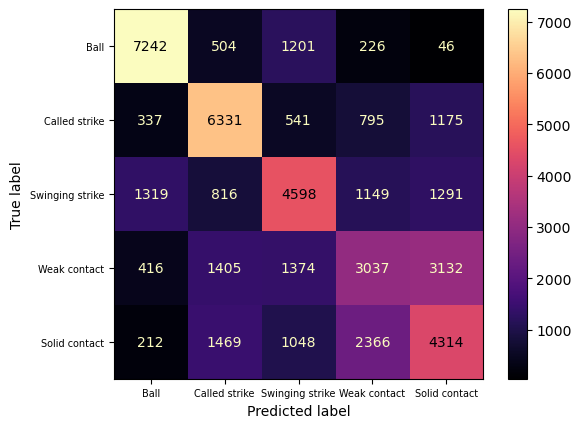

In [309]:
cm = confusion_matrix(y_test, y_pred_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Ball", "Called strike", "Swinging strike", "Weak contact", "Solid contact"])
cmd.plot(cmap="magma")
plt.xticks(fontsize=7)  # Reduce font size for x-axis labels
plt.yticks(fontsize=7)


acc_ball =cm[0,0] / sum(cm[0,:]) 
acc_cstrike = cm[1,1] / sum(cm[1,:]) 
acc_sw_strike = cm[2,2] / sum(cm[2,:]) 
acc_weak =cm[3,3] / sum(cm[3,:]) 
acc_solid =cm[4,4] / sum(cm[4,:]) 

print("accuracy of specific classes (sensitivity):","balls:",round(acc_ball,3), "called strikes:", round(acc_cstrike,3), "swinging strikes:", 
      round(acc_sw_strike,3), "Weak contact:",round(acc_weak,3), "Solid contact:", round(acc_solid,3))


acc_strikes = (cm[1,1] + cm[2,2]) / (sum(cm[1,:]) + sum(cm[2,:]))
acc_hit = (cm[3,3] + cm[4,4]) / (sum(cm[3,:]) + sum(cm[4,:]))


print("accuracy of strikes (combined):",round(acc_strikes,3))
print("accuracy of hits (combined):",round(acc_hit,3))

In [354]:
# Predict probabilities for all classes
y_pred_probs = model_xgb.predict_proba(X_test_xgb)


In [380]:
#output probabilities and combine with test data 
import copy 

data_test = copy.deepcopy(X_test)
data_test[["prob_Ball", "prob_CStrike", "prob_SWStrike", "prob_weak", "prob_solid"]] = y_pred_probs
data_test["y_pred"] = y_pred_test

y_actual = pd.Series(y_test, name = "y_actual")
data_test= pd.concat([data_test, y_actual], axis = 1)

data_test["max_prob"] = data_test[["prob_Ball","prob_CStrike", "prob_SWStrike",
                                   "prob_weak","prob_solid"]].max(axis=1) #highest probability that leads to predicted class

#remapping class names 
class_map = {0:'Ball', 1:'Called strike', 2:"Swinging strike" ,3:'Weak contact', 4:'Solid contact'}

#Apply the mapping to the column
data_test['y_pred'] = data_test['y_pred'].map(class_map)
data_test['y_actual'] = data_test['y_actual'].map(class_map)

#data_test.to_csv("testdata_with_predictions.csv")

In [35]:
data_test = pd.read_csv("testdata_with_predictions.csv")

Looking more closely at the probability predictions, we can plot a histogram and violin plots to show the distribution of the highest probabilites across the class:

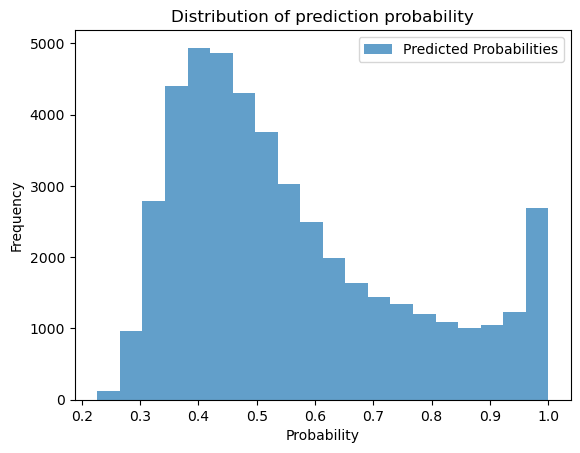

In [381]:
plt.hist(data_test["max_prob"], bins=20, alpha=0.7, label="Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Distribution of prediction probability")
plt.legend()
plt.show()

The histogram shows that the majority of prediction have around a 40% probablity of being predicted a given class which is quite low. Though this is higher than 'slightly above chance' which would be just over 20%. The histogram also shows large group where the probability of being predicted a given class was close to 100%. We can examine this by splitting out the predicted classes. 

In [382]:
#average predicted probability by class
data_test.groupby("y_pred")["max_prob"].mean()

y_pred
Ball               0.773612
Called strike      0.582721
Solid contact      0.454353
Swinging strike    0.534460
Weak contact       0.426842
Name: max_prob, dtype: float32

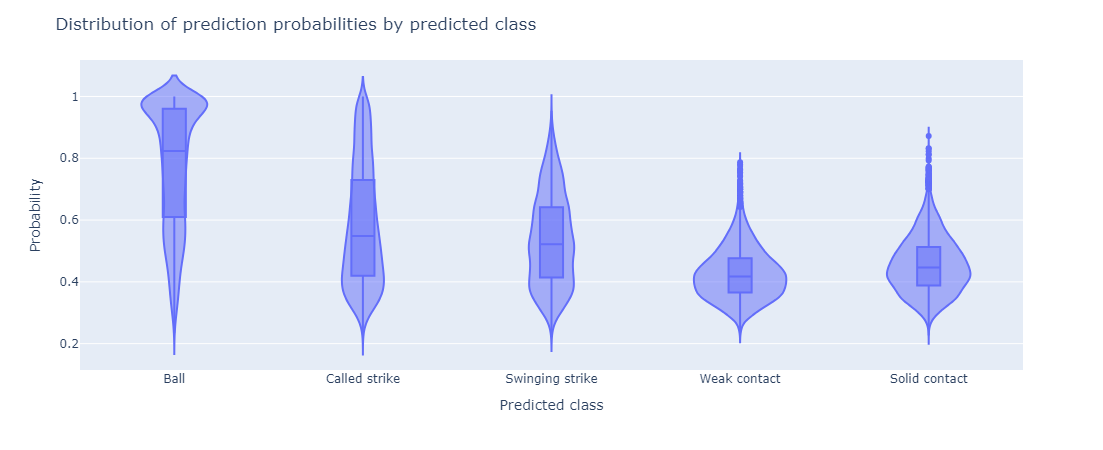

In [44]:
fig = px.violin(data_test, y="max_prob", x="y_pred",box=True,
                category_orders={"y_pred": ["Ball", "Called strike", "Swinging strike", "Weak contact", "Solid contact"]} )
fig.update_layout(
    title="Distribution of prediction probabilities by predicted class",
    xaxis_title="Predicted class",
    yaxis_title="Probability",
    width=1000,  # Adjust the width (in pixels)
    height=450  # Adjust the height (in pixels)
)
fig.show()

The overall means of the highest predicted probabilites by class as well as the violin plots show that balls have the highest predicted probabilites, whereas weak and solid contact have a high density of low prediction probabilities. Strikes are more spread out but also tend towards lower prediction probabilites.

### Conclusions

Overall there doesn't seem to be a lot of confidence in the predictions with the exception of balls. This is reflected both in the accuracy of prediction and the probability of being predicted a given class. Whilst this is not surprising, given these are sport outcomes which are very difficult to predict, there may be underlying relationships which are not possible to determine with the available data. 

There are a few findings of note however:  

1. The model is able to detect, at a 70% success rate, that a ball in the strike zone will be a called strike and therefore not swung at. This is an important finding when making management decisions especially for a tight game when getting a strike would be the most desired outcome. 
2. 
Further, although solid contact only has a 46% success rate, it’s being misclassified as weak contact 25% of the time. Combined, this makes over 70% (not including accurate predictions for a weak contact). Again, in a tight game a manager would want to get any type of hit over a strike out. 

To improve this model, a A larger dataset encompassing more baseball seasons as well as capturing the sequential aspects of a plate appearance would likely improve the accuracy of the model 